# Import libraries


In [90]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import io
np.set_printoptions(precision=15) #Sets precision

# Import data


In [ ]:
from google.colab import files
datos = files.upload()

**IMPORTANT NOTE**


The current notebook was performed using 10% of the original dataset, shortening overall runtime, subsampling by df.sample(frac=0.1, replace=False, random_state=1)

In [21]:
datos = pd.read_csv(io.BytesIO(datos['trips_2023_10percent.csv']))

# Helpful functions

In [35]:
def fecha_hora(df):
    ''' Splits "fecha_origen_recorrido" column into date and hour'''
    fecha_hora = df['fecha_origen_recorrido'].str.split(' ', expand=True)
    # Se almacena en un nuevo df
    fecha_hora.columns = ['Fecha','Hora']

    return fecha_hora

def obtener_dia_semana(fecha):
    '''Gets weekday name'''
    return datetime.datetime.strptime(fecha,'%Y-%m-%d').weekday()

def nombre_dia(df):
    '''Gets weekday name based on the number of the day'''
    dia = df.replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
    return dia

def momento_dia_fc(x):
    '''Moment of the day conversion'''
    if (x['hora_del_dia']>= '06:00:00') & (x['hora_del_dia']<= '12:00:00'):
        return '1.Morning'

    if (x['hora_del_dia']>='12:00:00') & (x['hora_del_dia'] <= '14:00:00'):
        return '2.Mid-day'

    if (x['hora_del_dia']>='14:00:00') & (x['hora_del_dia'] <= '19:00:00'):
        return '3.Afternoon'

    if (x['hora_del_dia']>'19:00:00') & (x['hora_del_dia'] <= '24:00:00'):
        return '4.Night'

    if (x['hora_del_dia']>'00:00:00') & (x['hora_del_dia'] < '06:00:00'):
        return '5.Early morning'


# Data wrangling and processing

In [22]:
datos.rename(columns={"género": "genero"}, inplace=True) #Rename columns

#Change comma by dot
datos['duracion_recorrido'] = datos['duracion_recorrido'].str.replace(',', '.')
datos['duracion_recorrido'] = datos['duracion_recorrido'] .astype('str').str.replace(r".", r"", regex=False)

#Use dict to convert data types
convert_dict = {'duracion_recorrido': float,
                'long_estacion_origen':float,
                'lat_estacion_origen':float,
                'long_estacion_destino':float,
                'lat_estacion_destino':float
                }
datos = datos.astype(convert_dict)

#Rename column to be more specific
datos.rename(columns={"duracion_recorrido": "duracion_recorrido_segs"}, inplace=True)
datos['duracion_min'] = datos['duracion_recorrido_segs'] / 60

#Keep rows with reasonable time trip duration
trip_limit = 60*3 #mins
datos = datos.loc[datos['duracion_min']< trip_limit]

#Check & treat NaNs, null values or empty cells (string, '').
datos.isna().sum().sum()
datos = datos.dropna()
datos.isnull().values.any() #No null values

#Split date and hour at beggining of trip
tiempo = fecha_hora(datos)

#Obtain weekday from trip's starting date
weekday_number = tiempo.Fecha.map(obtener_dia_semana)
datos['dia_de_la_semana'] = nombre_dia(weekday_number)

#Obtain moment of the day from trip's starting date
datos['hora_del_dia'] = tiempo.Hora
datos['momento_dia'] = datos.apply(lambda x: momento_dia_fc(x),1)

 # Top 10 stations used as check in / out

 To begin with our analysis, we firs inspect the following barplot, casting the main stations used as check in/out (i.e. as start or finishing point of the bike trip). This gives us a sense of which stations are most oftenly used.

 We can see that if we rank stations per usage, we get the top 10 arrangement. Pacifico and Cosntitucion are the main stations used, followed by Congreso and Plaza Italia, located next to major multi transportation transfer points (bus, train and underground( in the city of Buenos Aires.

[Text(0.5, 32.72222222222221, 'Count'),
 Text(256.3244949494949, 0.5, 'Station name (check in)')]

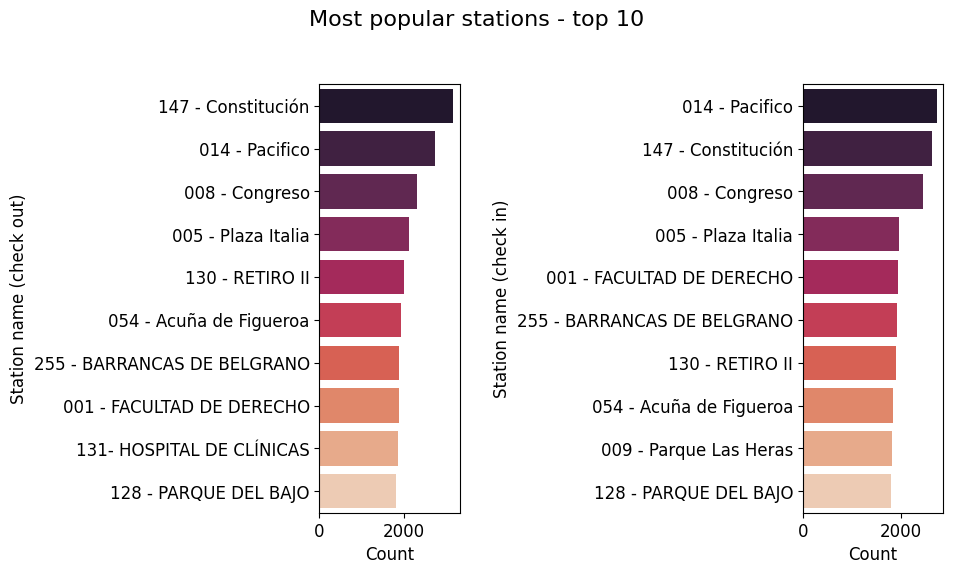

In [100]:
top_outs =  datos['nombre_estacion_origen'].value_counts()[:10].reset_index()
top_outs.rename(columns = {'index':'station', 'nombre_estacion_origen':'count_station'}, inplace=True)
top_ins =  datos['nombre_estacion_destino'].value_counts()[:10].reset_index()
top_ins.rename(columns = {'index':'station', 'nombre_estacion_destino':'count_station'}, inplace=True)

fig, axes = plt.subplots(1,2, figsize=(10,6), squeeze=False)
fig.suptitle('Most popular stations - top 10', size=16)
sns.barplot(ax = axes[0,0], x=top_outs.count_station, y=top_outs.station,  orient="h", palette = ("rocket") )
sns.barplot(ax = axes[0,1], x=top_ins.count_station, y=top_ins.station,  orient="h", palette = ("rocket") )
plt.tight_layout(pad=2)
axes[0,0].set(xlabel='Count',  ylabel='Station name (check out)')
axes[0,1].set(xlabel='Count',  ylabel='Station name (check in)')

# Number and duration of trips exploration

Next, we may ask: if we divide the daytime in discrete times of the day (morning, mid-day, etc), is there any category in which the bikes are most frequently used?

Based on the number of trips made per time of day, this system is more required during the afternoons. Then, it is more oftlenly needed during mornings and nights equally.

Text(0.5, 0, '')

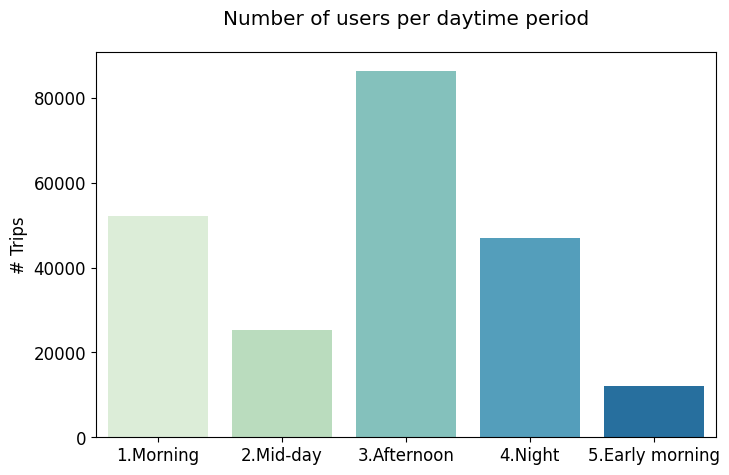

In [101]:
nViajes = datos.groupby(['momento_dia'])["Id_recorrido"].count().reset_index()
nViajes = nViajes.rename({"Id_recorrido" : "nro_de_viajes"}, axis = 1)

plt.figure(figsize=(8,5))
ax = sns.barplot(x="momento_dia", y="nro_de_viajes", data=nViajes, palette = 'GnBu')
ax.set_facecolor("white")
plt.title('Number of users per daytime period', y=1.05)
plt.xlabel('Daytime period')
plt.ylabel('# Trips')
plt.xlabel('')

In the upcoming analysis, we can assess how the trip duration fluctuates over the time of day. We do not see major changes, albeit during afternoon the mean duration seems to be a bit higher.

Note: for unsuscribed users, the time limit per trip is 30 min and a maximum of 4 trips per day per user at the moment of writing this notebook.

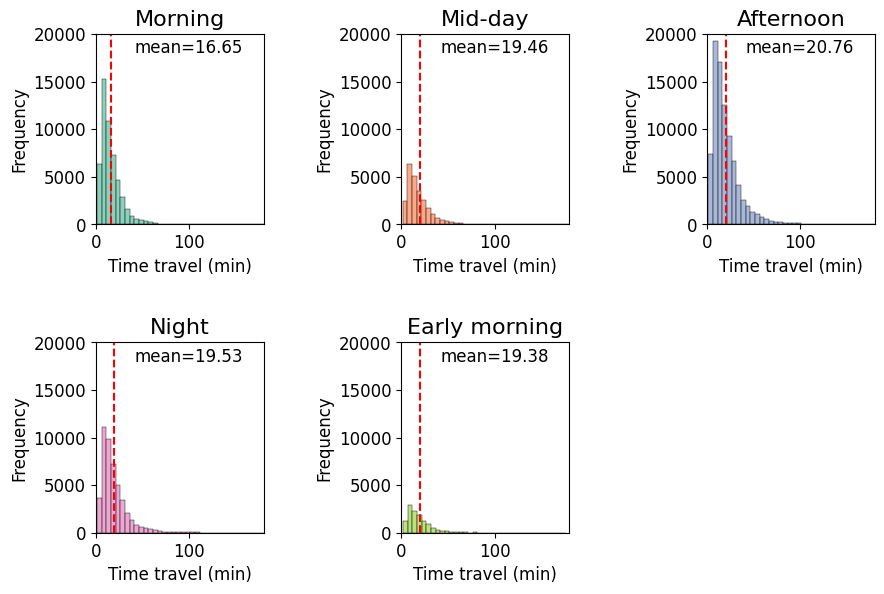

In [103]:
# Function for time-travel distributions
def plot_time_travel_distrib(df, ubicacion, varX, labelX, labelY, titulo, bineo, paletaColor, unColor, xmin, xmax, ymin, ymax):
    '''Function to plot distribution for each time period'''
    sns.histplot(ax=axes[ubicacion], data=df ,x=varX, binwidth=bineo, color=paletaColor[unColor])
    axes[ubicacion].set(xlabel=labelX, ylabel=labelY)
    axes[ubicacion].set(xlim = (xmin, xmax), ylim = (ymin, ymax))
    axes[ubicacion].set_title(titulo,fontsize=16)
    axes[ubicacion].axvline(x=df[varX].mean(), color='red', ls='--')
    axes[ubicacion].text(100, 18000, f'mean={round(df[varX].mean(), 2)}', horizontalalignment='center', fontweight=8)

fig, axes = plt.subplots(2,3, figsize=(10,7), squeeze=False)
plt.rcParams['font.size'] = '12'
plt.tight_layout(pad=5)
paletaColor = sns.color_palette("Set2")
bineo = 5
var_x = 'duracion_min'
x_label = 'Time travel (min)'
y_label = 'Frequency'
yMax = 20000
xMax = 180

plot_time_travel_distrib(datos[datos['momento_dia'] == '1.Morning'], (0,0),
                         var_x, x_label, y_label, 'Morning', bineo, paletaColor, 0, 0, xMax, 0, yMax)
plot_time_travel_distrib(datos[datos['momento_dia'] == '2.Mid-day'], (0,1),
                         var_x, x_label, y_label, 'Mid-day', bineo, paletaColor, 1, 0, xMax, 0, yMax)
plot_time_travel_distrib(datos[datos['momento_dia'] == '3.Afternoon'], (0,2),
                         var_x, x_label, y_label, 'Afternoon', bineo, paletaColor, 2, 0, xMax, 0, yMax)
plot_time_travel_distrib(datos[datos['momento_dia'] == '4.Night'], (1,0),
                         var_x, x_label, y_label, 'Night', bineo, paletaColor, 3, 0, xMax, 0, yMax)
plot_time_travel_distrib(datos[datos['momento_dia'] == '5.Early morning'], (1,1),
                         var_x, x_label, y_label, 'Early morning', bineo, paletaColor, 4, 0, xMax, 0, yMax)
fig.delaxes(axes[1,2]) #Delete last unused grid location



# Time travel per day of week or daytime

To continue with our analysis, we'll investigate now how many trips are completed and the mean travel duration by day of the week jointly.

We can appreciate that these two variables covary inversely. Bikes are more frequently used during weekdays, with shorter trip durations. Meanwhile, during weekends, the bikes are less required in number but trips take longer.

This could be associated with the end users make use of this system. During workdays, people may use this system to make short/fast commutes from one point to another, while on weekends users may use this for entertainment and pleasure.


[Text(0.5, 21.722222222222214, ''),
 Text(506.0744949494949, 0.5, 'Mean time travel (min)')]

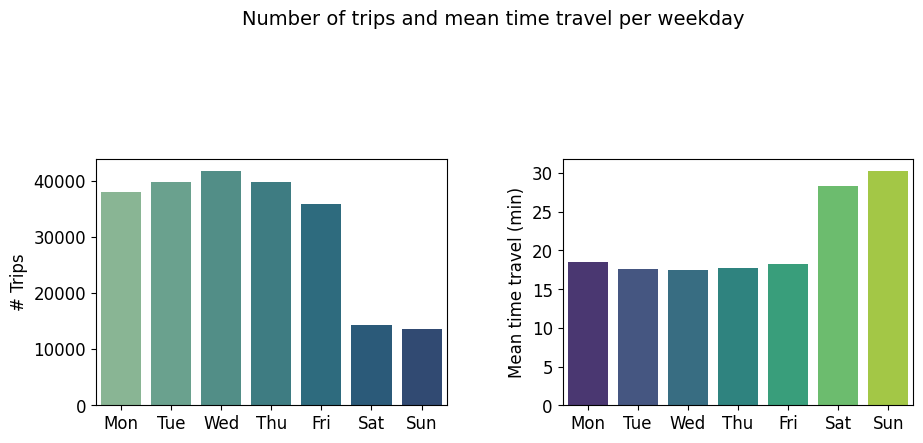

In [29]:
conteos_dia_semana = datos.groupby(['dia_de_la_semana'])['duracion_min'].describe()[['count', 'mean']].reset_index()
conteos_momento_dia= datos.groupby(['momento_dia'])['duracion_min'].describe()[['count', 'mean']].reset_index()
semana = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

fig, axes = plt.subplots(1,2, figsize=(10,5), squeeze=False)
fig.suptitle('Number of trips and mean time travel per weekday', size=14)
plt.tight_layout(pad=4)
sns.barplot(ax = axes[0,0], data = conteos_dia_semana, x='dia_de_la_semana', y = 'count', order = semana, palette = 'crest')
sns.barplot(ax = axes[0,1], data = conteos_dia_semana, x='dia_de_la_semana', y = 'mean', order = semana, palette = 'viridis')
axes[0,0].set(xlabel='',  ylabel='# Trips')
axes[0,1].set(xlabel='',  ylabel='Mean time travel (min)')

# Total users per check-out time

The following heatmap allows a more detailed exploration of the system's usage trend on an hour-by-hour basis.

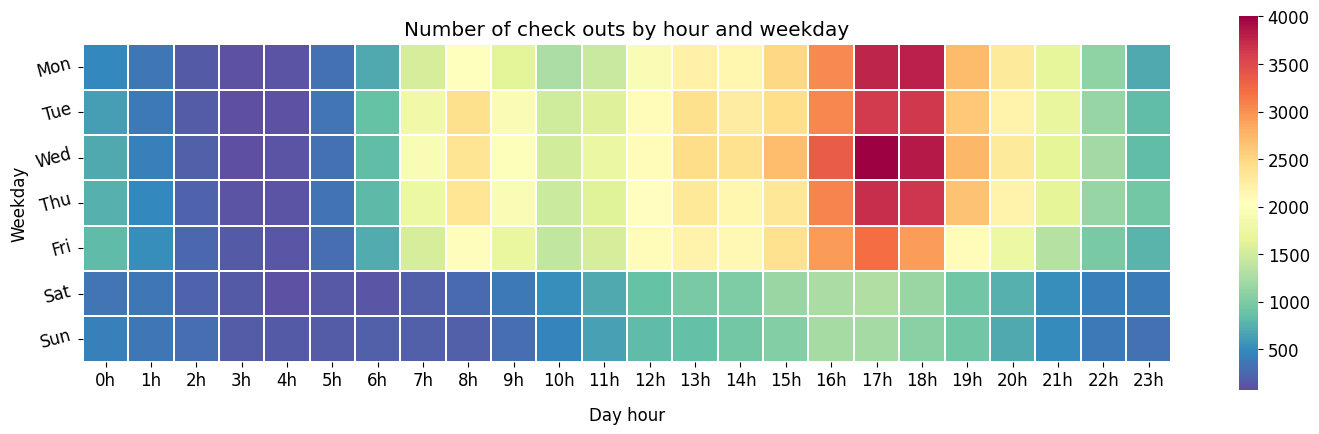

In [104]:
pivot1 = pd.pivot_table(datos, values="momento_dia",
                        index=pd.to_datetime(datos['fecha_origen_recorrido']).dt.weekday,
               columns=pd.to_datetime(datos['fecha_origen_recorrido']).dt.hour, aggfunc = 'count',fill_value=0)

pivot2 = pd.pivot_table(datos, values="momento_dia",
                        index=pd.to_datetime(datos['fecha_origen_recorrido']).dt.hour,
               columns=["dia_de_la_semana"], aggfunc = 'count',fill_value=0)

plt.figure(figsize=(15,10))
ax = sns.heatmap(pivot1, square=True, cmap='Spectral_r', linewidths=.1,cbar_kws={"shrink": .4})
plt.setp(ax.xaxis.get_majorticklabels(), rotation=360 )
ax.set_title("Number of check outs by hour and weekday")
ax.set_xlabel("Day hour", labelpad = 12)
ax.set_ylabel("Weekday")
labels = [item.get_text()+''+'h' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation = 15)
plt.tight_layout(pad=2)

# Demand of stations per month

How about a year-wise analysis? Are there monthly fluctuations and why?

The following graph shows us that the system (measured as number of trips) is highly demanded all year round except for the winter season (roughly months 5, 6, 7). This could come in handy to plan repairments on the stations or bikes based on when the system is more/less required.



Text(0, 0.5, '# Trips')

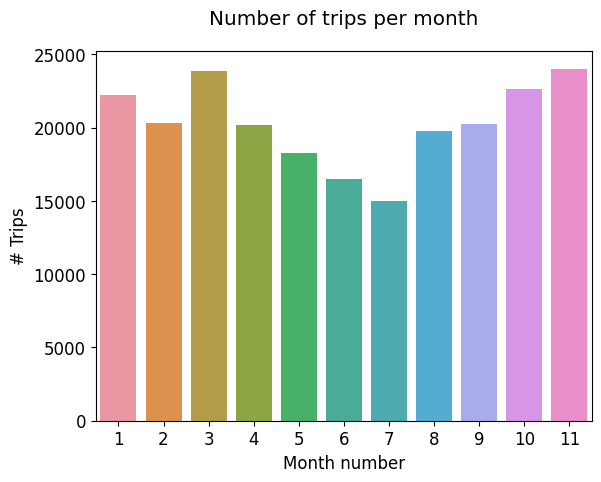

In [62]:
datos['mes_del_anio'] = pd.to_datetime(datos['fecha_origen_recorrido']).dt.month
data_x_mes = datos.groupby('mes_del_anio').size().reset_index()
data_x_mes.columns = ['mes','n_usos']

ax = sns.barplot(data_x_mes, x="mes", y="n_usos")
plt.title('Number of trips per month', y=1.05)
plt.xlabel('Month number')
plt.ylabel('# Trips')

# Cartographic analysis


In [ ]:
#Loading the map: load .shp file
MAP = files.upload()

In [83]:
mapa = gpd.read_file('/barrios_wgs84.shp')

In [84]:
mapa['representativo'] = mapa['geometry'].representative_point() #Generate representative point of each geom
ma_points = mapa.copy()
ma_points.set_geometry("representativo", inplace = True) # Copy df for labels

In [ ]:
#Upload stations
ESTACIONES = files.upload()

In [85]:
estaciones = gpd.read_file('/IE-Estaciones.shp')

In [86]:
#Count checkouts per neighborhood
estaciones_x_barrio = estaciones.groupby(["BARRIO"]).size().reset_index()
estaciones_x_barrio.columns = ['BARRIO', 'n_est']
N_EST = mapa.set_index('BARRIO').join(estaciones_x_barrio.set_index('BARRIO'))
N_EST['n_est'] = N_EST['n_est'].fillna(0) #Replace nan by 0 for the map


 ## Density of stations per neigborhood

 Let's see where are the stations distributed along the city (i.e. station density). With this map, we can see that the most populated neighborhoods in terms of stations are located in the central-northern part of Buenos Aires, while ther seems to be a downgradient upon south, where the number of stations starts to decay.

<ipython-input-91-175c7e0322db>:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)# add the colorbar to the figure


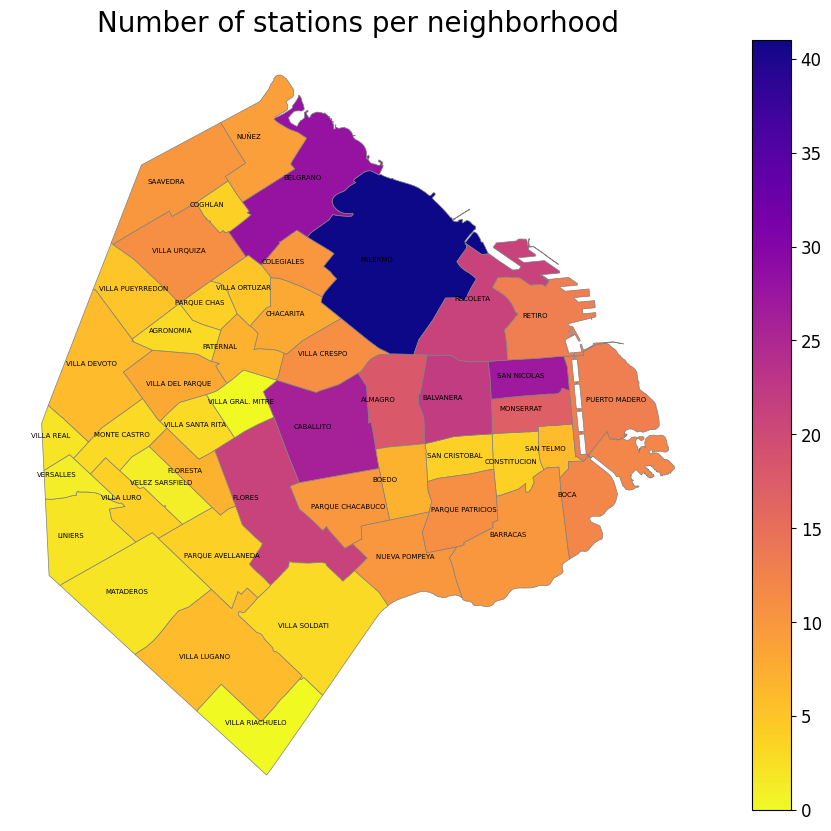

In [91]:
fig, ax= plt.subplots(figsize= (12,10))
N_EST.plot(column='n_est', cmap='plasma_r', linewidth=0.5, ax=ax, edgecolor='grey')
ax.axis('off')# remove the axis
ax.set_title('Number of stations per neighborhood', fontdict={'fontsize': '20', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='plasma_r', norm=plt.Normalize(vmin=0, vmax=max(N_EST['n_est']))) # Create colorbar as a legend
sm._A = []# empty array for the data range
cbar = fig.colorbar(sm)# add the colorbar to the figure
#Add label for each neighborhood
for x, y, label in zip(ma_points.geometry.x, ma_points.geometry.y, ma_points["BARRIO"]):
    plt.text(x-0.01, y, label, fontsize = 5, color= 'black')


## Number of checkouts per neigborhood

Finally, we'll dive into how many trips are performed (in terms of bike check outs) per neighborhood.

We can see that this map mildly aligns with the previous one. In the northern and central neighborhoods of the city, the higher numerosity of stations correlates positively with the number of trips. However, in the western neighborhoods, albeit having a mild number of stations, this system is not heavliy required. Overall, this type of analysis might help deciding where to locate future new stations in the network.

In [92]:
#Populate original df with the station's neighborhood
# Crear un GeoDataFrame a partir de 'datos'
gdf_datos = gpd.GeoDataFrame(datos, geometry=gpd.points_from_xy(datos['long_estacion_origen'], datos['lat_estacion_origen']))
# Crear un GeoDataFrame a partir de 'mapa'
gdf_mapa = gpd.GeoDataFrame(mapa, geometry='geometry')
# Realizar la operación de espacio para unir los dos GeoDataFrames
datos_con_barrio = gpd.sjoin(gdf_datos, gdf_mapa, how='left', op='within')
# La columna 'barrio' en 'datos_con_barrio' contiene ahora la información deseada
datos['barrio'] = datos_con_barrio['BARRIO']
#Count checkouts per neighborhood
viajes_x_barrio = datos.groupby("barrio").size().reset_index()
viajes_x_barrio.columns = ['BARRIO', 'n_usos']
#Are all points inside a neighborhood? Drop empty rows if not
viajes_x_barrio['BARRIO'].replace('', np.nan, inplace=True)
viajes_x_barrio = viajes_x_barrio.dropna()
#Merge  the two df's
merged = mapa.set_index('BARRIO').join(viajes_x_barrio.set_index('BARRIO'))
merged['n_usos'] = merged['n_usos'].fillna(0) #Replace nan by 0 for the map


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-92-73bced6599ff>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  datos_con_barrio = gpd.sjoin(gdf_datos, gdf_mapa, how='left', op='within')


<ipython-input-94-f4ba4a0f39c5>:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)# add the colorbar to the figure


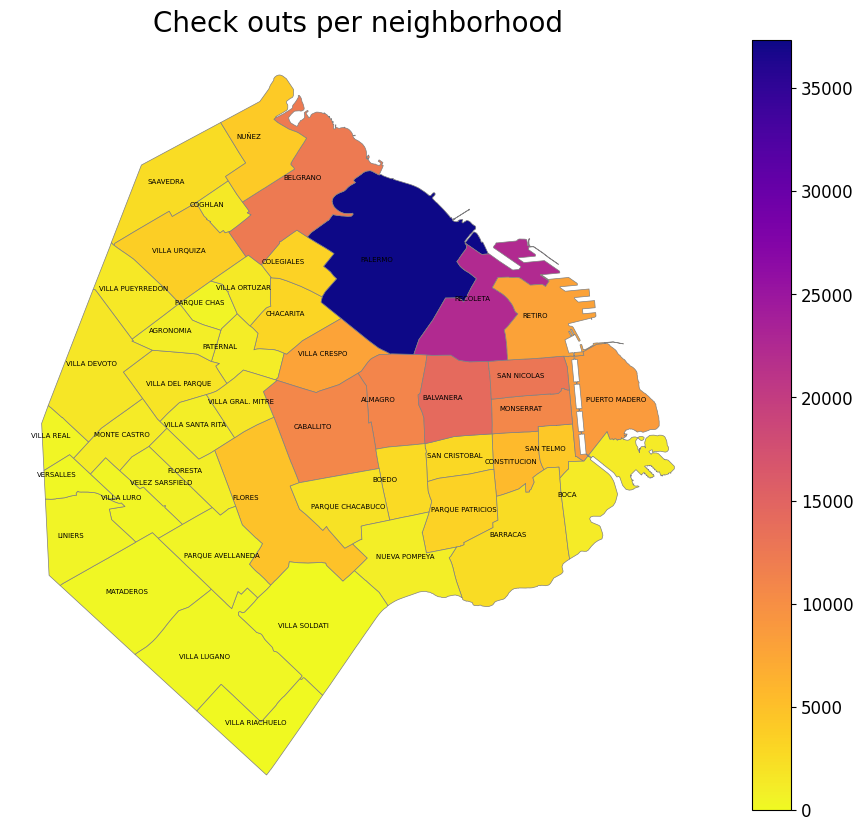

In [94]:
fig, ax= plt.subplots(figsize= (12,10))
merged.plot(column='n_usos', cmap='plasma_r', linewidth=0.5, ax=ax, edgecolor='grey')
ax.axis('off')# remove the axis
ax.set_title('Check outs per neighborhood', fontdict={'fontsize': '20', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='plasma_r', norm=plt.Normalize(vmin=0, vmax=max(merged['n_usos']))) # Create colorbar as a legend
sm._A = []# empty array for the data range
cbar = fig.colorbar(sm)# add the colorbar to the figure
#Add label for each neighborhood
for x, y, label in zip(ma_points.geometry.x, ma_points.geometry.y, ma_points["BARRIO"]):
    plt.text(x-0.01, y, label, fontsize = 5, color= 'black')